<a href="https://colab.research.google.com/github/YaninaK/churn-prediction/blob/main/notebooks/02_Baseline_model_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование оттока клиентов - нейросетевая модель.

## [EDA](https://github.com/YaninaK/churn-prediction/blob/main/notebooks/01_EDA.ipynb)

[Ссылка на данные](https://drive.google.com/file/d/1TAVECAfnel9lPfcpfel6qXhZSW2yNqdX/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/YaninaK/churn-prediction.git -q

In [3]:
%cd churn-prediction

/content/churn-prediction


In [4]:
!git pull -q

In [5]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "churn_prediction"))

In [6]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf

from data.make_dataset import load_data
from models import train
from models.LSTM_embeddings_model import get_LSTM_model
from models.utilities import get_initial_bias_and_class_weight, plot_loss

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
PATH = '/content/drive/MyDrive/ML_projects/06_Churn_prediction/'

## 1. Загрузка данных

In [8]:
data = load_data(PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   20468 non-null  int64  
 1   annualincome                          20468 non-null  int64  
 2   calldroprate                          20468 non-null  float64
 3   callfailurerate                       20468 non-null  float64
 4   callingnum                            20468 non-null  int64  
 5   customerid                            20468 non-null  int64  
 6   customersuspended                     20468 non-null  object 
 7   education                             20468 non-null  object 
 8   gender                                20468 non-null  object 
 9   homeowner                             20468 non-null  object 
 10  maritalstatus                         20468 non-null  object 
 11  monthlybilledam

## 2. Подготовка данных

In [9]:
(
    lstm_artifacts, nn_model_dataset, selected_features,
) = train.data_preprocessing_pipeline(data)

[seq_train, seq_valid, scaler_lstm] = lstm_artifacts
[X_train, X_valid, y_train, y_valid] = nn_model_dataset

## 3. Model

In [10]:
vocab_s = X_train['state'].unique().tolist()
n_labels_s = len(vocab_s)
vocab_e = X_train['education'].unique().tolist()
vocab_o = X_train['occupation'].unique().tolist()
n_features_other = len(selected_features)

params = {
    'input_sequence_length': 3,
    'n_features': 2,
    'n_units': 8,
    'vocab_s': vocab_s,
    'n_labels_s': n_labels_s,
    'embedding_size_s': 4,
    'vocab_e': vocab_e,
    'vocab_o': vocab_o,
    'n_features_other': n_features_other,
    'n_units_others': 8,
    'n_units_all': 16,
}

In [11]:
model_path = "models/LSTM_emb_model_v1.keras"
history_path = "models/model_LSTM_emb_training_history_v1.joblib"

regenerate = False
if regenerate:
    initial_bias, class_weight = get_initial_bias_and_class_weight(y_train)
    lstm_model = get_LSTM_model(**params, output_bias=initial_bias)

    n_epochs = 100
    batch_size = 64
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 3e-2 * 0.95**epoch
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_prc",
        patience=20,
        min_delta=1e-06,
        verbose=1,
        mode="max",
        restore_best_weights=True,
    )

    history = lstm_model.fit(
        [
            seq_train,
            X_train["state"],
            X_train["education"],
            X_train["occupation"],
            X_train[selected_features],
        ],
        y_train,
        epochs=n_epochs,
        validation_data=(
            [
                seq_valid,
                X_valid["state"],
                X_valid["education"],
                X_valid["occupation"],
                X_valid[selected_features],
            ],
            y_valid,
        ),
        class_weight=class_weight,
        batch_size=batch_size,
        verbose=0,
        callbacks=[reduce_lr, early_stopping],
        shuffle=True,
        workers=-1,
        use_multiprocessing=True,
    )
    lstm_model.save(PATH + model_path)
    joblib.dump(history, PATH + history_path)

else:
    lstm_model = tf.keras.models.load_model(PATH + model_path)
    history = joblib.load(PATH + history_path)

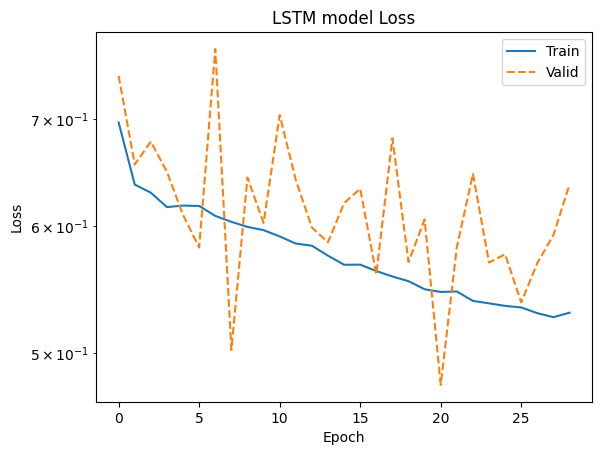

In [12]:
plot_loss(history)

In [13]:
results = lstm_model.evaluate(
    [
        seq_train,
        X_train['state'],
        X_train['education'],
        X_train['occupation'],
        X_train[selected_features]
    ],
    y_train,
    batch_size=64,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6337


In [14]:
baseline_results = lstm_model.evaluate(
    [
        seq_valid,
        X_valid['state'],
        X_valid['education'],
        X_valid['occupation'],
        X_valid[selected_features]
    ],
    y_valid,
    batch_size=64,
    verbose=0
)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(f'{name} : {value}')

loss : 0.643356442451477
cross entropy : 0.643356442451477
Brier score : 0.23514311015605927
tp : 206.0
fp : 1205.0
tn : 1395.0
fn : 52.0
accuracy : 0.5601819157600403
precision : 0.14599575102329254
recall : 0.7984496355056763
auc : 0.703681468963623
prc : 0.15596725046634674
